In [26]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["JAX_PLATFORMS"] = "cpu"
import sys
sys.path.append('../')

from pathlib import Path
import numpy as np
import bayesflow as bf
import random as rd
import utils as u
import visualizer as v
import diagnoser as d
import simulation_models.modelloader as ml
import surrogate_methods.surrogatebuilder as sb
from abi.abi_base import ABI
import surrogate_methods as sm
import matplotlib.pyplot as plt
from collections import defaultdict
# set random seed
rd.seed(0)
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
base_results_path = "../results/micp_posterior"
results_path = os.path.join(base_results_path, "prior_param_4_extended_poly_degree_3/infnet_splinecouplingflow_sumnet_none")
results_path_ua_sabi = os.path.join(results_path, "2025-08-27_11-43-03")
config_file = os.path.join(results_path_ua_sabi, "config_uasabi.json")
config = u.read_config(config_file)
config.output_path = base_results_path
config.micp.data_path = "../data/MICP/full_complexity_model"

diag = d.Diagnoser(config)
vis = v.Visualizer(config)

modelloader = ml.ModelLoader(config)
model = modelloader.get_model()
param_names = model.get_param_names()

surrogatebuilder = sb.SurrogateBuilder(config, model)
surrogate = surrogatebuilder.build_surrogate()
surrogate.load_path = results_path_ua_sabi
surrogate.load_all_fits()

/data/homes/reiser/.conda/envs/sabi_env_bf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:14:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (1.6%)
	Chain 1 had 246 iterations at max treedepth (98.4%)
	Chain 2 had 250 iterations at max treedepth (100.0%)
	Chain 3 had 250 iterations at max treedepth (100.0%)
	Chain 4 had 250 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 4 divergent transitions (1.6%)
	Chain 1 had 246 iterations at max treedepth (98.4%)
	Chain 2 had 250 iterations at max treedepth (100.0%)
	Chain 3 had 250 iterations at max treedepth (100.0%)
	Chain 4 had 250 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC 

Figure 1: Total Sobol Indices

[7.986695199169915e-05, 0.004798932356909626, 9.699147123773008e-05, 0.991752176469958]


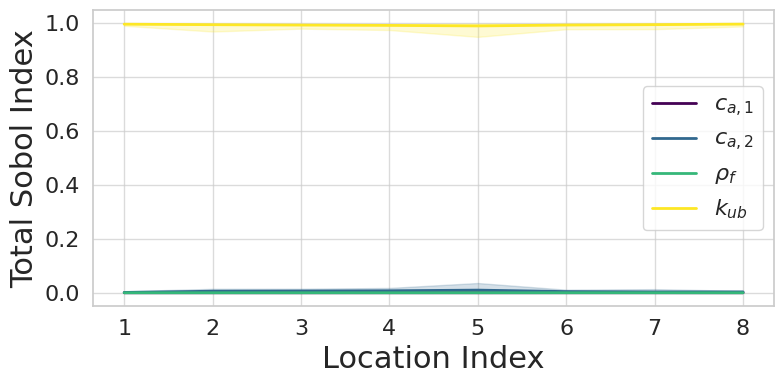

../results/micp_posterior


In [4]:
sobol_maps = diag.compute_sobol_indices(surrogate, model.get_param_names())
print([np.median(sobol_maps[key]) for key in sobol_maps.keys()])
vis.plot_sobols(sobol_maps)
print(config.output_path)

Figure 2.1: Prior Predictive Plot (original prior range)

(25, 8)


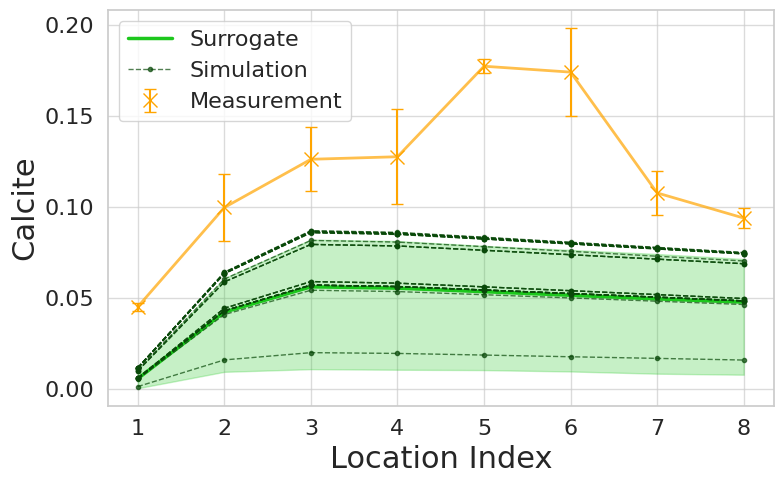

In [7]:
model.prior_param_4_upper = 0.5e-3
sigmaI = model.sigmaI_measurements
model._sigmaI = 0
out_params_mc, out_params_mc, out_observations_mc = model.load_abi_data(split="train", surrogate=surrogate)
measurement = model.load_ct_measurements()['observations'].flatten()
_,_,_,_,out_simulation = model.load_sobol_data(location=config.micp.locations)
print(out_simulation.shape)  # shape (25, 8)
vis.plot_surr_prior_predictive(
    out_observations=out_observations_mc,
    out_simulation=out_simulation,
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    kub_upper=model.prior_param_4_upper,
    save_name="micp_orig_prior_predictive"
)

Figure 2.2: Prior Predictive Plot (adjusted prior range)

(25, 8)


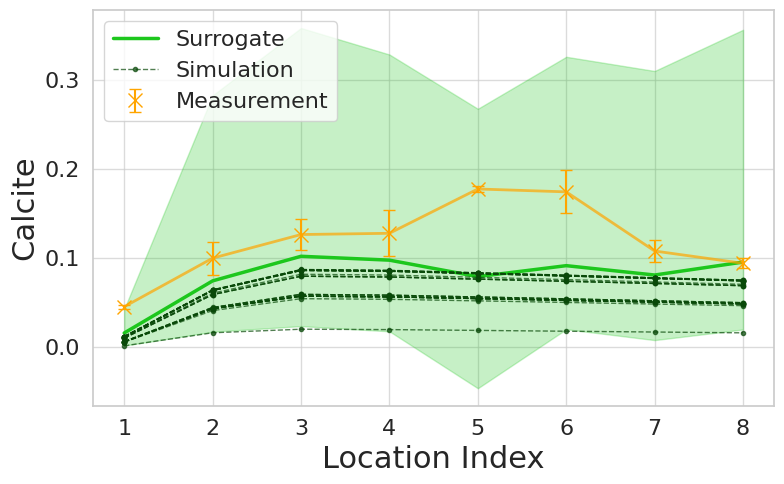

In [8]:
model.prior_param_4_upper = 1.5e-3
sigmaI = model.sigmaI_measurements
model._sigmaI = 0
out_params_mc, out_params_mc, out_observations_mc = model.load_abi_data(split="train", surrogate=surrogate)
measurement = model.load_ct_measurements()['observations'].flatten()
_,_,_,_,out_simulation = model.load_sobol_data(location=config.micp.locations)
print(out_simulation.shape)  # shape (25, 8)
vis.plot_surr_prior_predictive(
    out_observations=out_observations_mc,
    out_simulation=out_simulation,
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    kub_upper=model.prior_param_4_upper,
    save_name = "micp_adj_prior_predictive_kub"
)

Location Plots (degree=3)

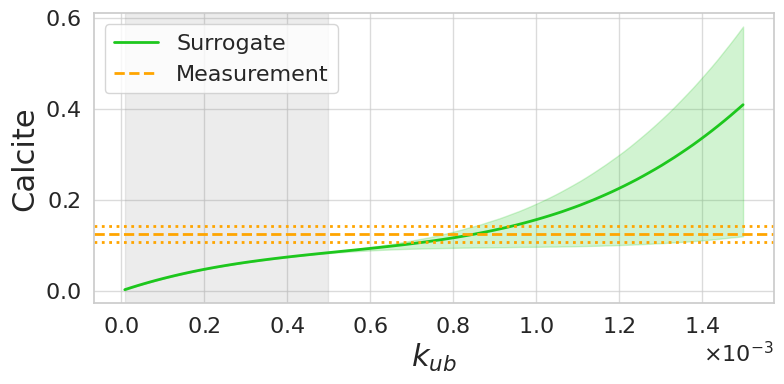

In [132]:
kub_min, kub_max = model.get_param_bounds()[param_names[3]]
kub_max_original = 5e-4
kub_range = np.linspace(kub_min, kub_max, 100)

vis = v.Visualizer(config)

vis.plot_surrogate_output_vs_kub(
    surrogate=surrogate,
    out_params_template=out_params_mc,
    locations=config.micp.locations,
    location_index=2,  # third location
    param_4_values=kub_range,
    train_bounds=(kub_min, kub_max_original),
    measurement=measurement,
    measurement_sigma=sigmaI,
    param_names=param_names
)

Figure 3: Posteriors for real measurement data

8.997087e-07
dict_keys(['abi_low_budget', 'mcmc_point', 'mcmc_e_post', 'sabi', 'uasabi'])
dict_keys(['abi_low_budget', 'mcmc_point', 'mcmc_e_post', 'sabi', 'uasabi'])


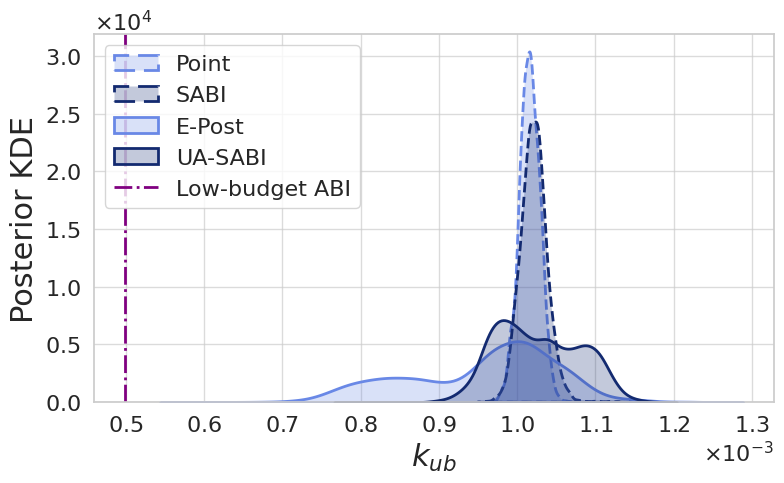

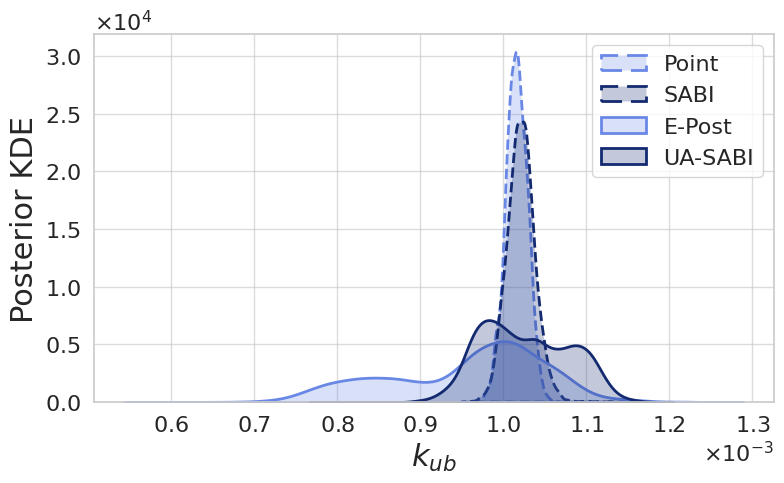

In [3]:
draws_adjusted_prior_dict = u.load_parameter_draws_from_runs(results_path, model)
print(np.std(draws_adjusted_prior_dict['abi_low_budget'][param_names[-1]]))
print(draws_adjusted_prior_dict.keys())
print(draws_adjusted_prior_dict.keys())
vis.figsize = (8, 5)
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[3]], ["mcmc_point", "sabi", "mcmc_e_post", "uasabi", "abi_low_budget"], save_name="micp_posterior_kde_kub_all_methods")
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[3]], ["mcmc_point", "sabi", "mcmc_e_post", "uasabi"])

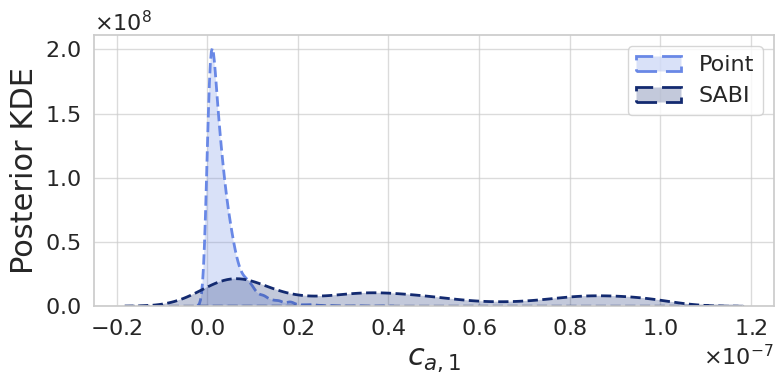

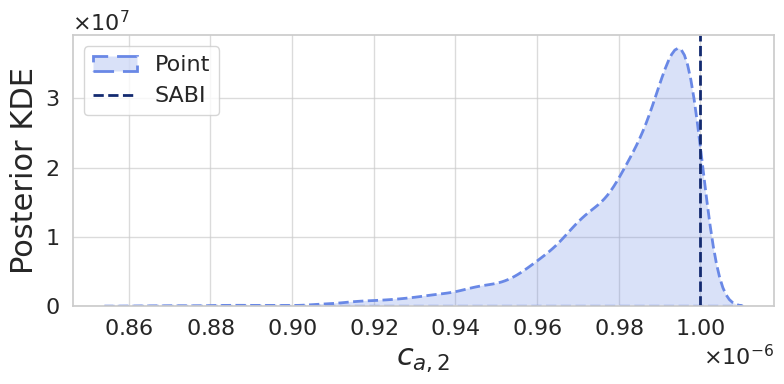

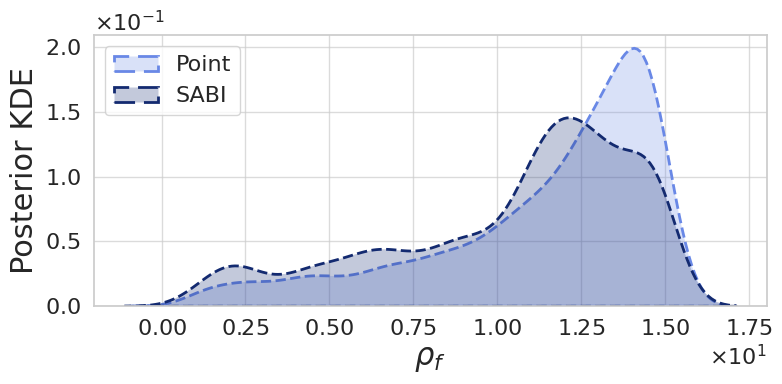

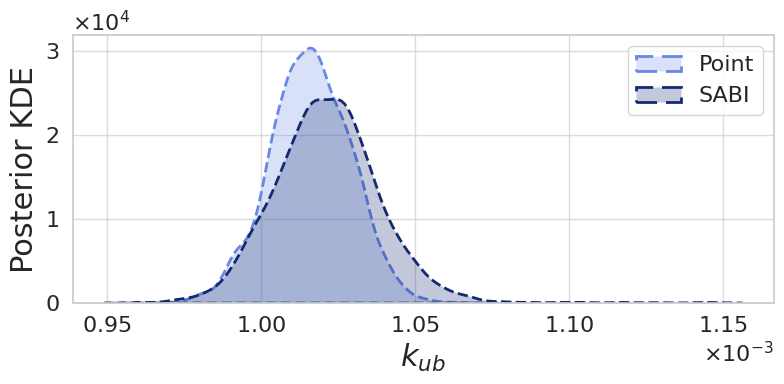

In [107]:
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[0]], ["mcmc_point", "sabi"])
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[1]], ["mcmc_point", "sabi"])
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[2]], ["mcmc_point", "sabi"])
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, [param_names[3]], ["mcmc_point", "sabi"])

Fig: Posterior of all params with adjusted prior

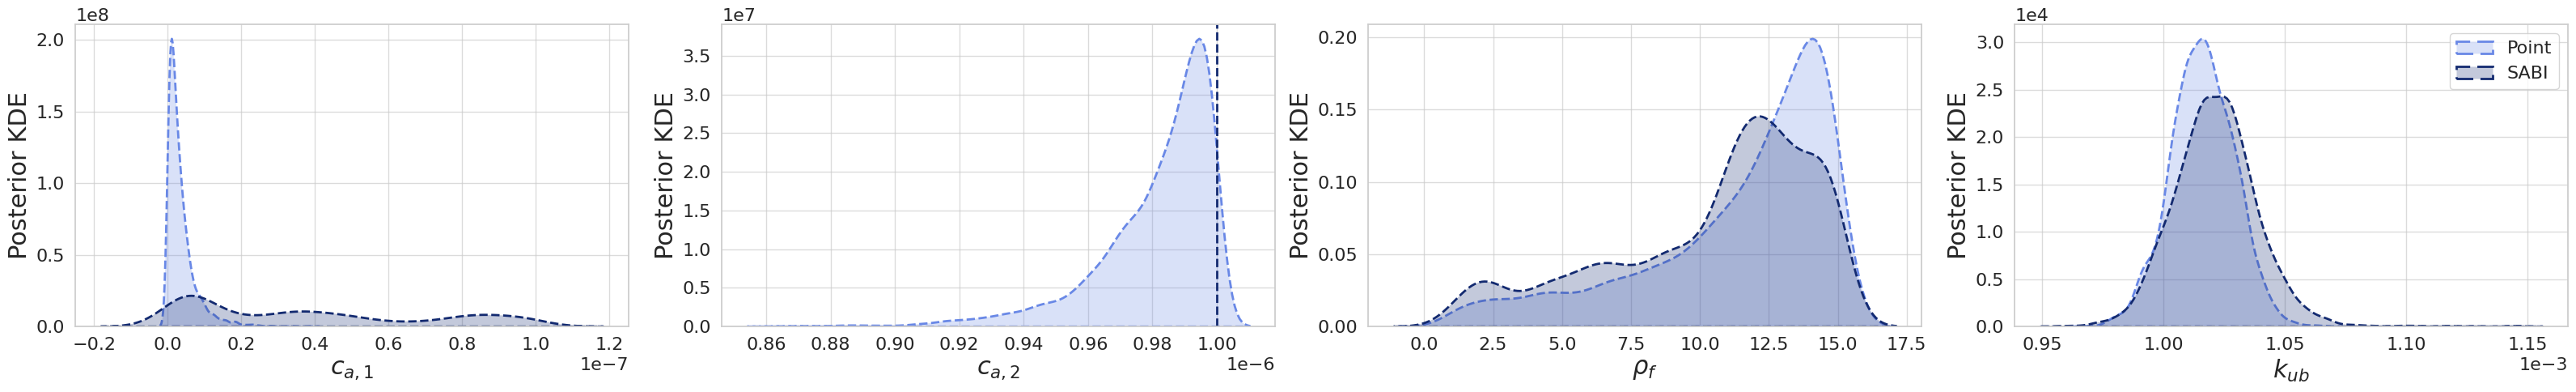

In [75]:
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, param_names, ["mcmc_point", "sabi"], ncols=4)

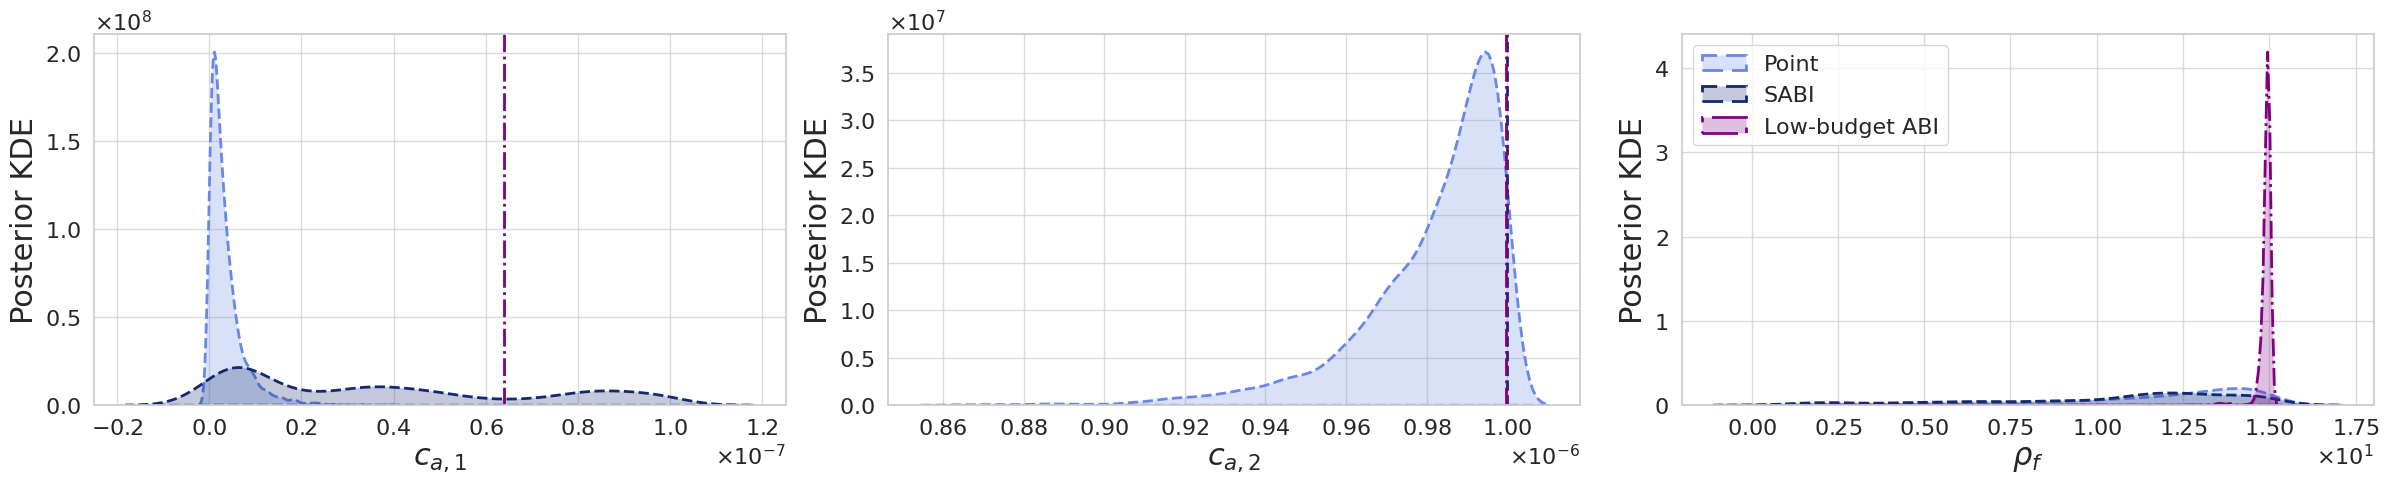

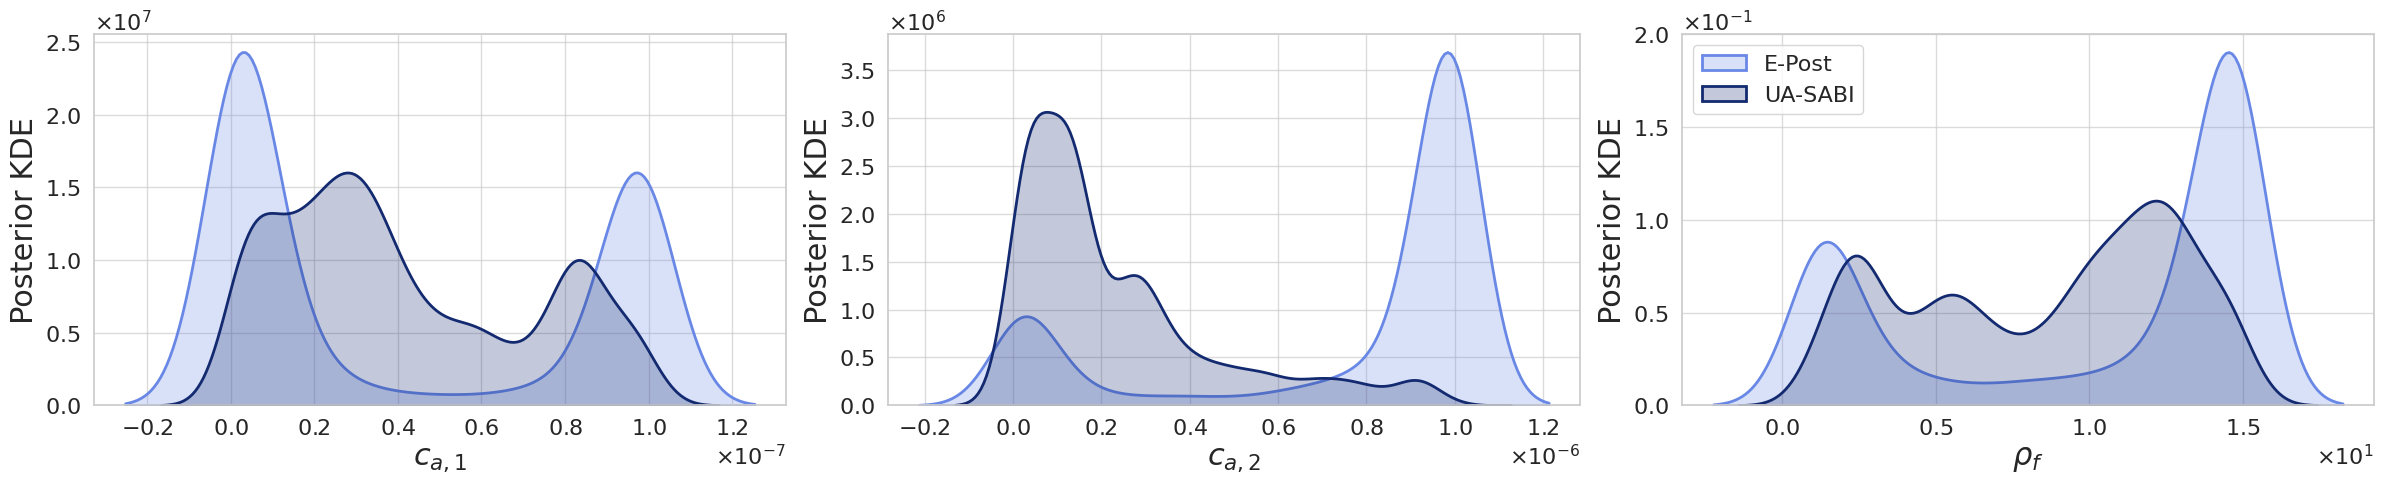

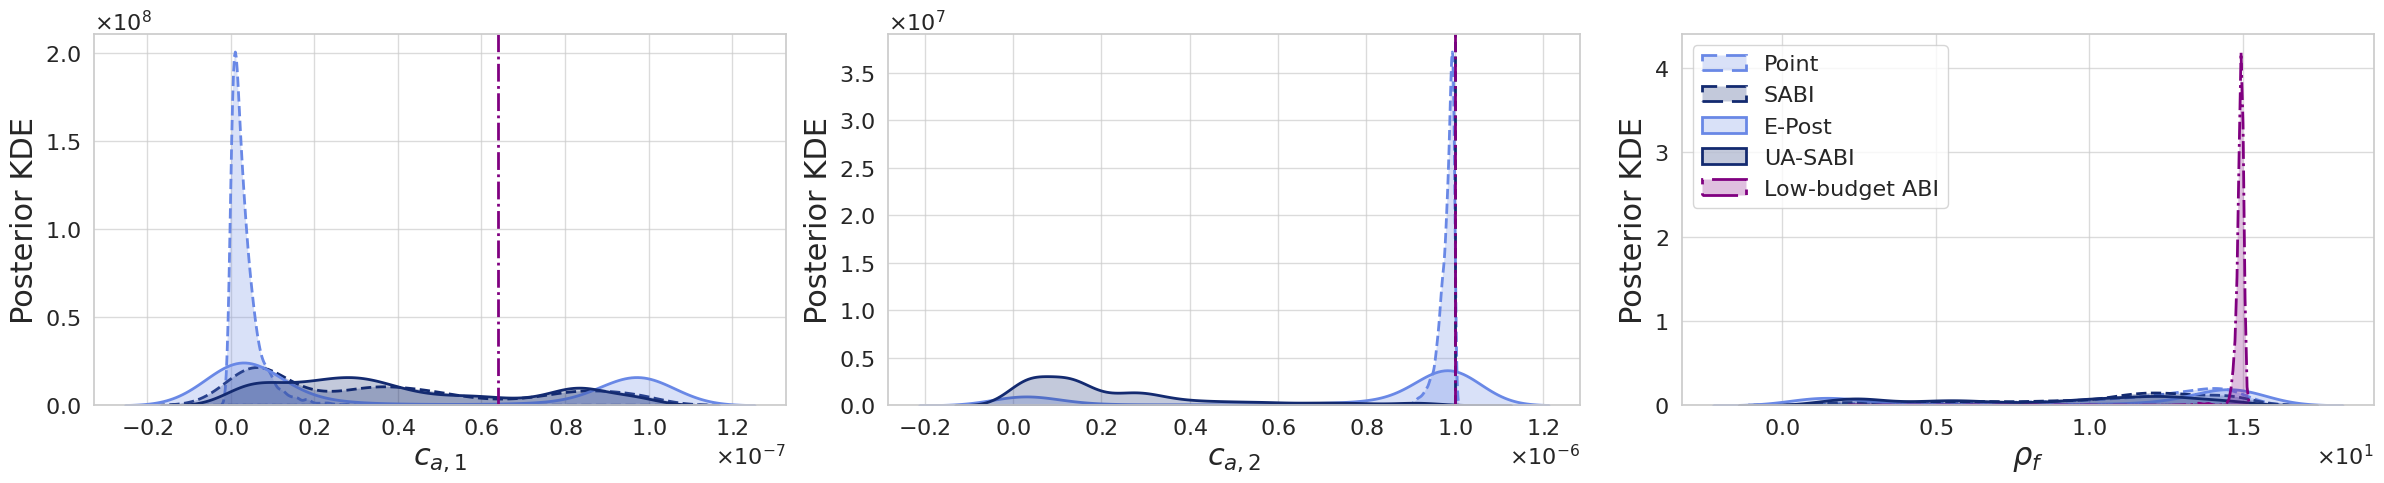

In [6]:
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, param_names[:-1], ["mcmc_point", "sabi", "abi_low_budget"], ncols=3)
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, param_names[:-1], ["mcmc_e_post", "uasabi"], ncols=3)
vis.plot_comparison_multi_posterior_kde(draws_adjusted_prior_dict, param_names[:-1], ncols=3, save_name="micp_rem_posteriors_apdx")

Fig: Posterior of all parameters with original prior

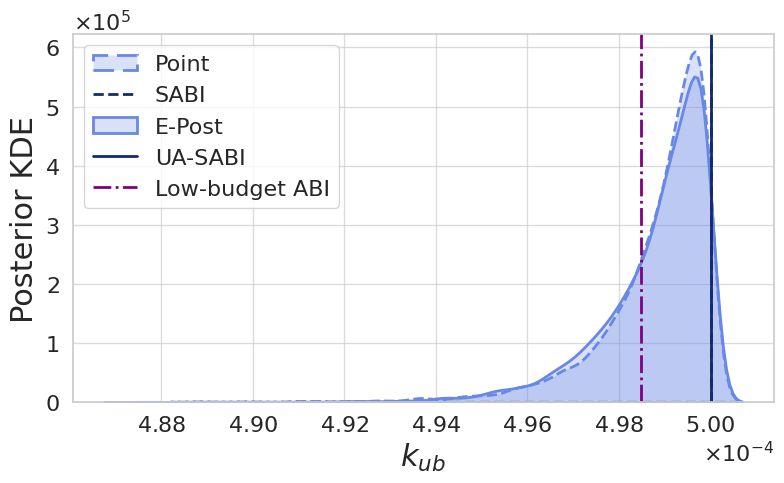

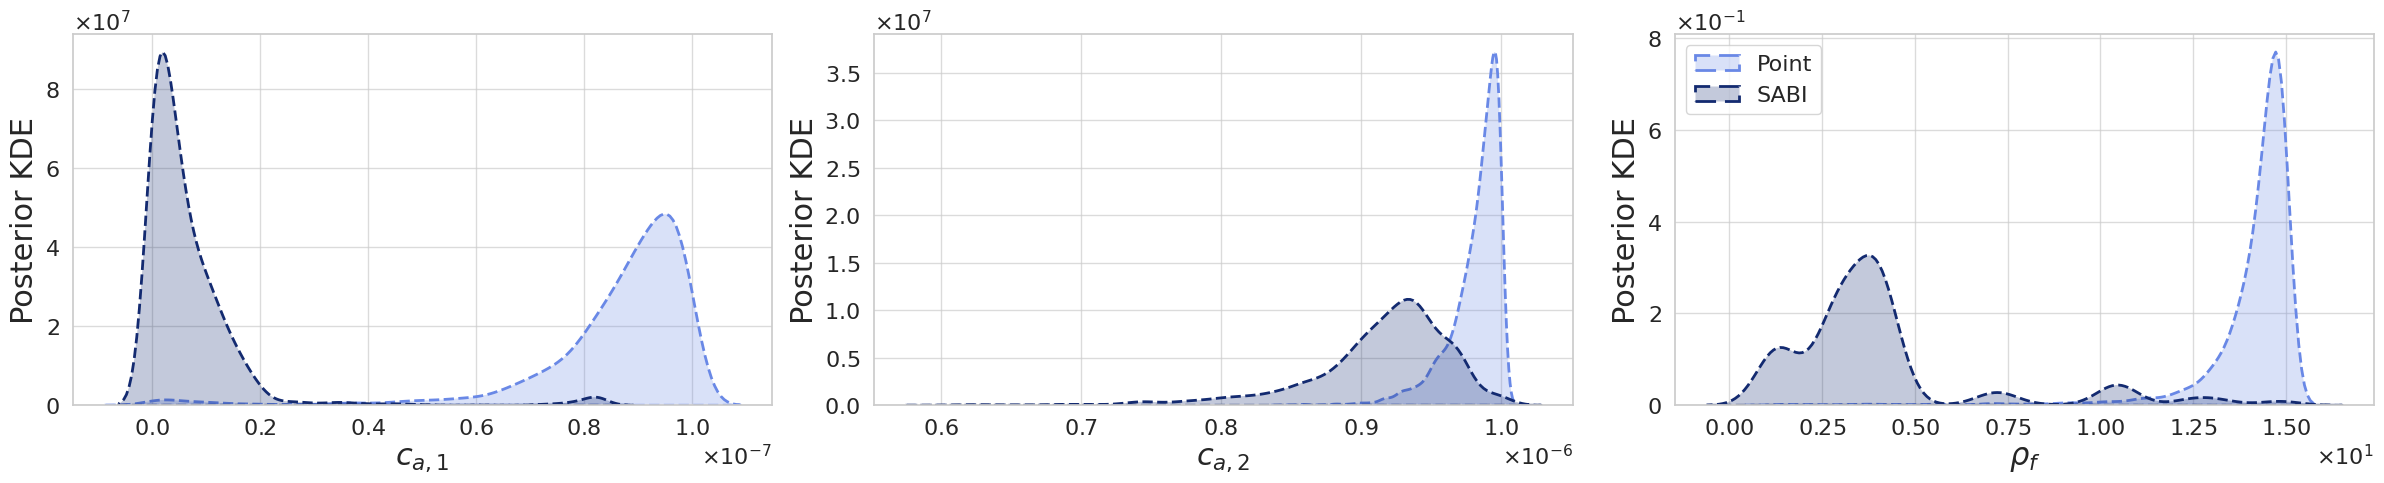

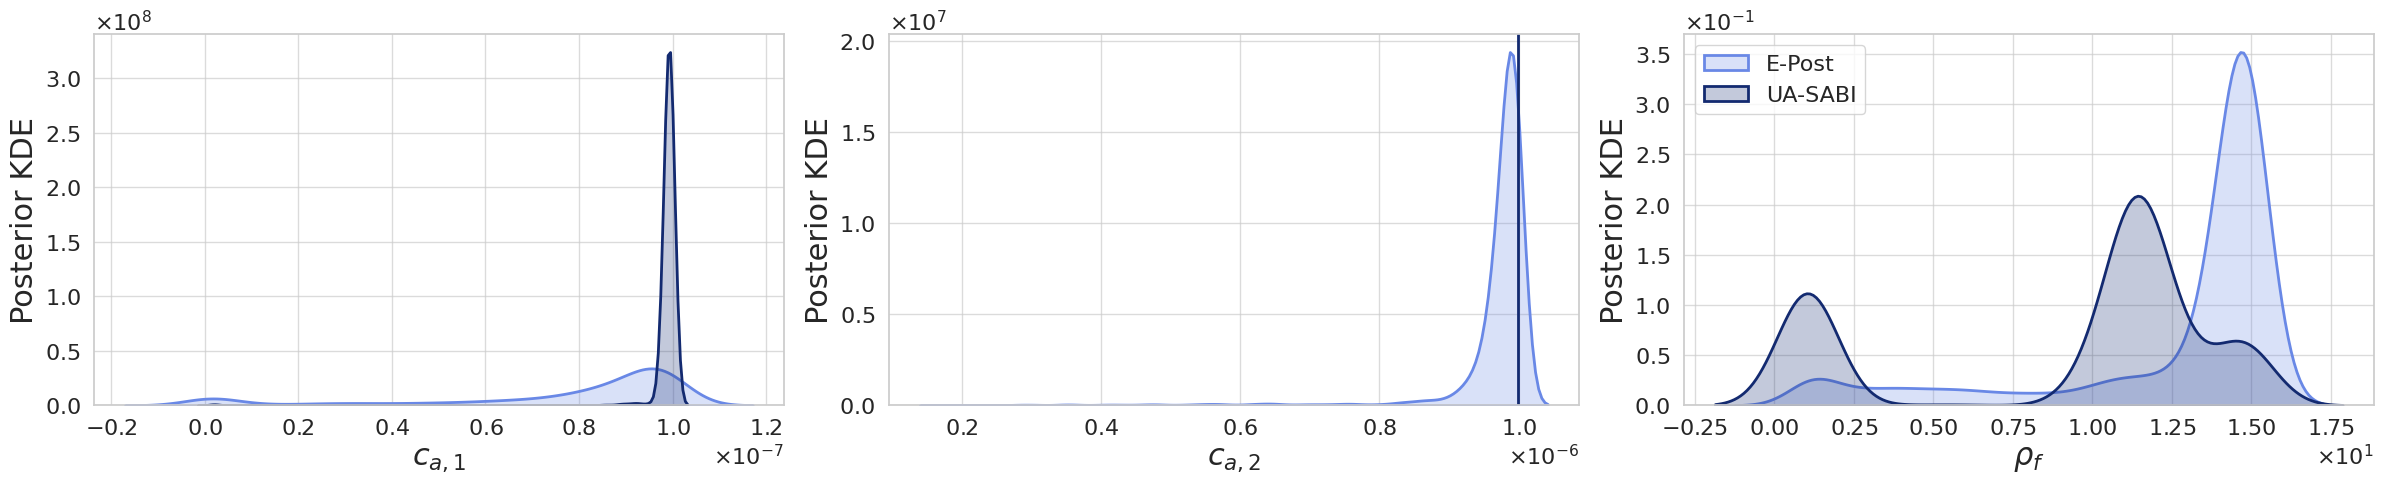

In [9]:
results_path_orig_prior = os.path.join(base_results_path, "prior_param_4_original_poly_degree_3")
draws_orig_prior_dict = u.load_parameter_draws_from_runs(results_path_orig_prior, model)
vis.plot_comparison_multi_posterior_kde(draws_orig_prior_dict, [param_names[3]], save_name="micp_kub_posteriors_apdx")
vis.plot_comparison_multi_posterior_kde(draws_orig_prior_dict, param_names[:-1], ["mcmc_point", "sabi"], ncols=3)
vis.plot_comparison_multi_posterior_kde(draws_orig_prior_dict, param_names[:-1], ["mcmc_e_post", "uasabi"], ncols=3)

Figure 4: Runtime

In [ ]:
from datetime import datetime
# load the logged E-Post inference times per dataset
runtime_path_e_post = "../results/micp-runtimes_juck/2025-08-29_16-40-58/out"
with open(os.path.join(runtime_path_e_post, "times.dat"), "r") as f:
    times = [datetime.strptime(line.strip(), "%Y-%m-%d %H:%M:%S") for line in f if line.strip()]
epost_runtimes = {}
for i in range(1, len(times)):
    diff = (times[i] - times[0]).total_seconds()
    epost_runtimes[str(i)] = diff
print(epost_runtimes)

{'1': 138.0, '2': 281.0, '3': 423.0, '4': 564.0, '5': 704.0, '6': 853.0, '7': 992.0, '8': 1132.0, '9': 1278.0, '10': 1432.0}


In [ ]:
import json
import time

# load the ABI runtimes
uasabi_runtimes  = {}
times_path = os.path.join(results_path_ua_sabi, "diagnosis", "time.json")
with open(times_path, 'r', encoding='utf-8') as file:
    times = json.load(file)
uasabi_trainingtime = times["abi_training_time"]
uasabi_runtimes[config.out.n_datasets] = times["abi_training_time"] + times["abi_sampling_time"]

all_n_datasets = list(epost_runtimes.keys())
abi = ABI(config, model, None)
_, approximator = abi.load(results_path_ua_sabi)
out_datasets, _, _ = u.load_out(results_path_ua_sabi)
for n_datasets in all_n_datasets:
    print(n_datasets)
    conditions = {'observations': out_datasets['observations'][:int(n_datasets), :]}
    print(conditions['observations'].shape)
    start_time = time.time()
    parameter_draws = approximator.sample(conditions=conditions, num_samples=config.out.n_param_samples)
    end_time = time.time()
    sampling_time = end_time - start_time

    uasabi_runtimes[n_datasets] = uasabi_trainingtime + sampling_time

1
(1, 8)
2
(2, 8)
3
(3, 8)
4
(4, 8)
5
(5, 8)
6
(6, 8)
7
(7, 8)
8
(8, 8)
9
(9, 8)
10
(10, 8)


In [ ]:
# save runtimes
save_path = "../results/micp-runtimes_juck"
with open(os.path.join(save_path, 'epost_runtimes.json'), 'w') as f:
    json.dump({str(k): v for k, v in epost_runtimes.items()}, f)
with open(os.path.join(save_path, 'uasabi_runtimes.json'), 'w') as f:
    json.dump({str(k): v for k, v in uasabi_runtimes.items()}, f)

In [ ]:
# load runtimes
load_path = "../results/micp-runtimes_juck"
with open(os.path.join(load_path, 'epost_runtimes.json'), 'r') as f:
    epost_runtimes = {int(k): v for k, v in json.load(f).items()}
with open(os.path.join(load_path, 'uasabi_runtimes.json'), 'r') as f:
    uasabi_runtimes = {int(k): v for k, v in json.load(f).items()}

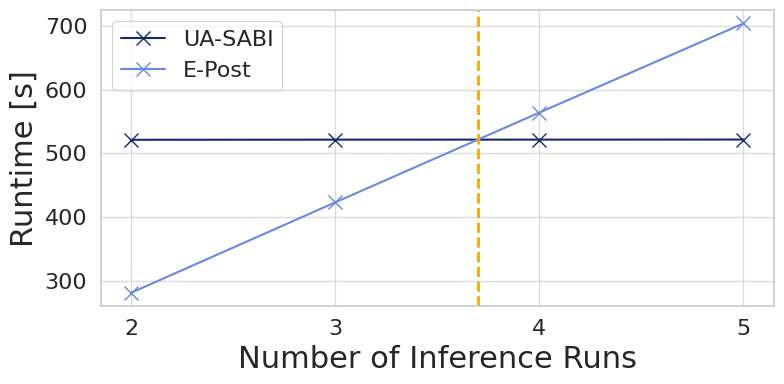

In [48]:
runtimes_to_plot = [2, 3, 4, 5]
uasabi_runtimes_plot = {k: v for k, v in uasabi_runtimes.items() if k in runtimes_to_plot}
epost_runtimes_plot = {k: v for k, v in epost_runtimes.items() if k in runtimes_to_plot}
vis.compare_runtimes(uasabi_runtimes_plot, epost_runtimes_plot)

In [34]:
out_datasets['observations'].shape

(200, 8)

Figure: Convergence check of E-Post

(100, 1, 4) (100, 1, 4)


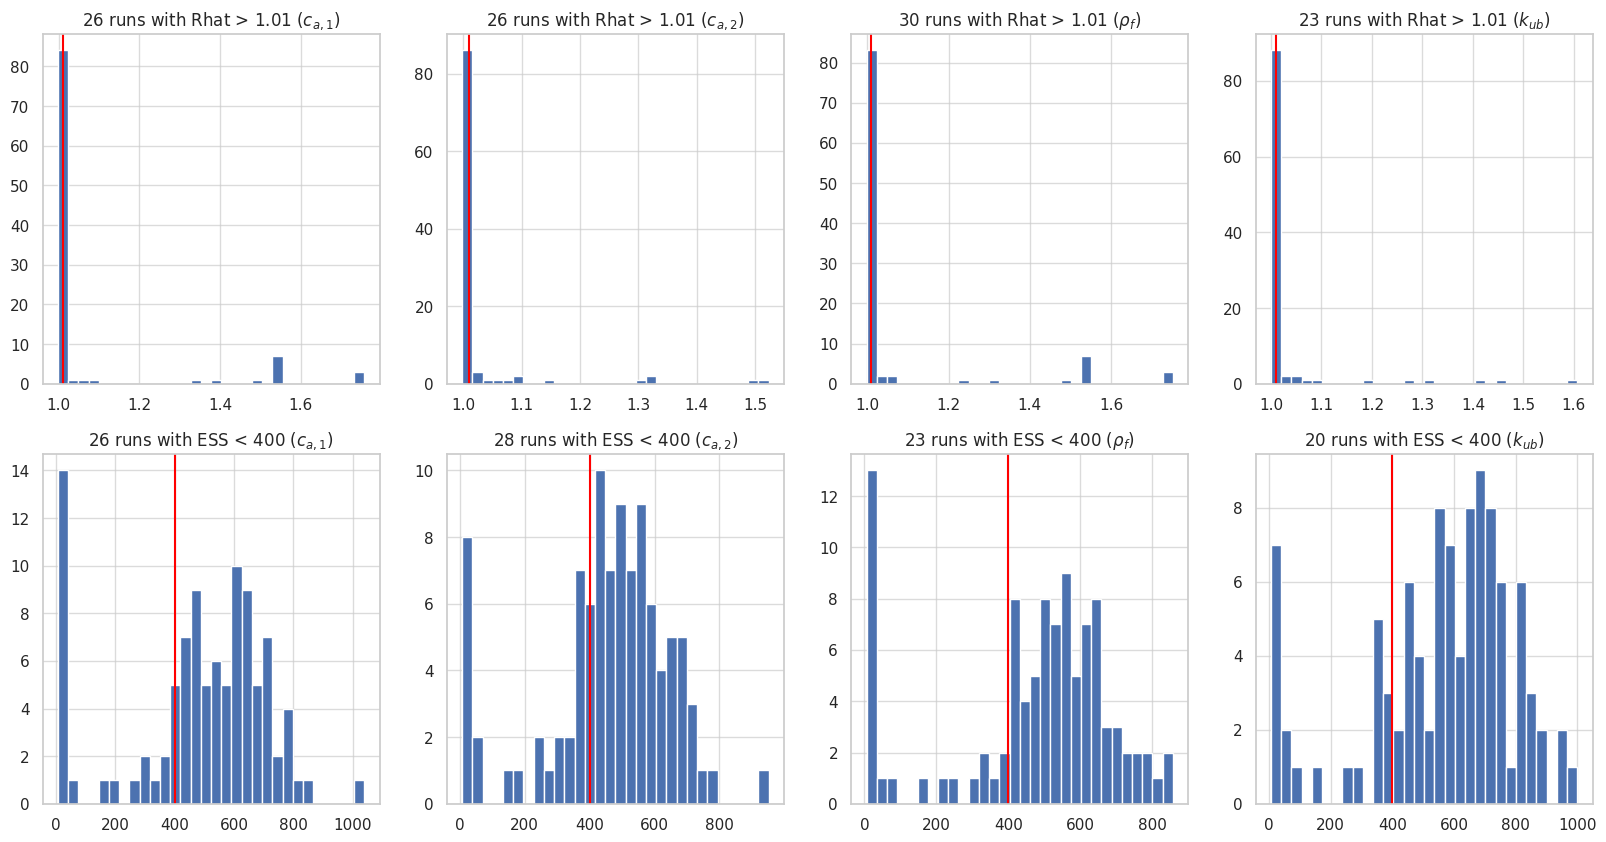

In [ ]:
path = "../results/micp_posterior/mcmc_convergence/2025-08-28_14-07-12/figures/mcmc_parameter_inference"
mcmc_diagnostics = np.load(os.path.join(path, "mcmc_diagnostics.npz"))
rhats = mcmc_diagnostics['rhats']
esses = mcmc_diagnostics['esses']
print(rhats.shape, esses.shape)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

for param_i, param in enumerate(param_names):
    rhat_param = rhats[:, :, param_i].flatten()
    ess_param = esses[:, :, param_i].flatten()
    ax[0, param_i].hist(rhat_param, bins=30)
    ax[0, param_i].set_title(f"{(rhat_param > 1.01).sum()} runs with Rhat > 1.01 ({param})")
    ax[0, param_i].axvline(1.01, color="red")
    ax[1, param_i].hist(ess_param, bins=30)
    ax[1, param_i].set_title(f"{(ess_param < 400).sum()} runs with ESS < 400 ({param})")
    ax[1, param_i].axvline(400, color="red")


In [ ]:
def get_posterior_predictive(method):
    param_draws = draws_adjusted_prior_dict[method]
    x1 = param_draws[param_names[0]].reshape(-1)
    x2 = param_draws[param_names[1]].reshape(-1)
    x3 = param_draws[param_names[2]].reshape(-1)
    x4 = param_draws[param_names[3]].reshape(-1)
    random_idx = np.random.randint(low=0, high=(surrogate.n_total_samples-1), size=x1.shape[0])
    if method in ["mcmc_e_post", "uasabi"]:
        out_observations = np.array([
            surrogate.evaluate(x1, x2, x3, x4, location=loc, time=1, random_idx=random_idx)
            for loc in config.micp.locations
        ]).T  # shape (n_samples, n_locations)
    elif method in ["mcmc_point", "sabi"]:
        out_observations = np.array([
            surrogate.evaluate_point(x1, x2, x3, x4, location=loc, time=1)
            for loc in config.micp.locations
        ]).T  # shape (n_samples, n_locations)
    # out_observations = np.random.normal(out_observations, sigmaI)
    return out_observations

Figure: Posterior Predictive Plots

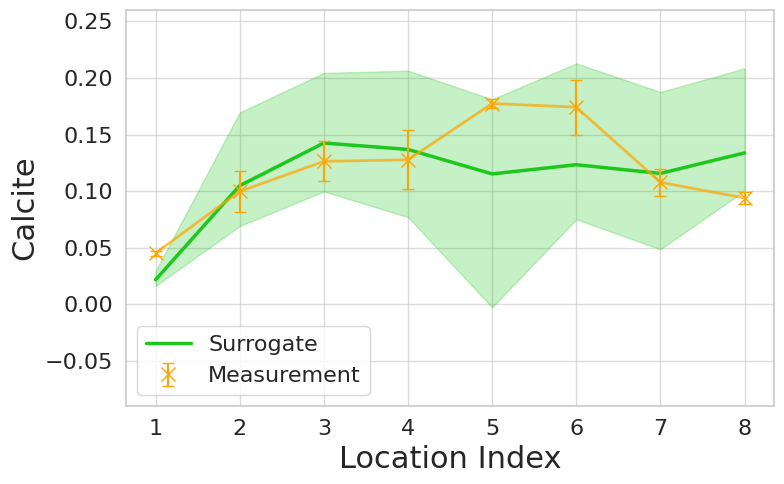

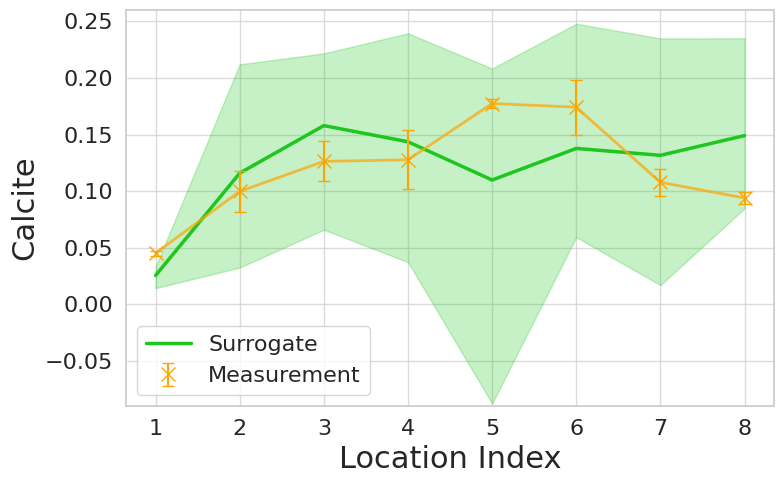

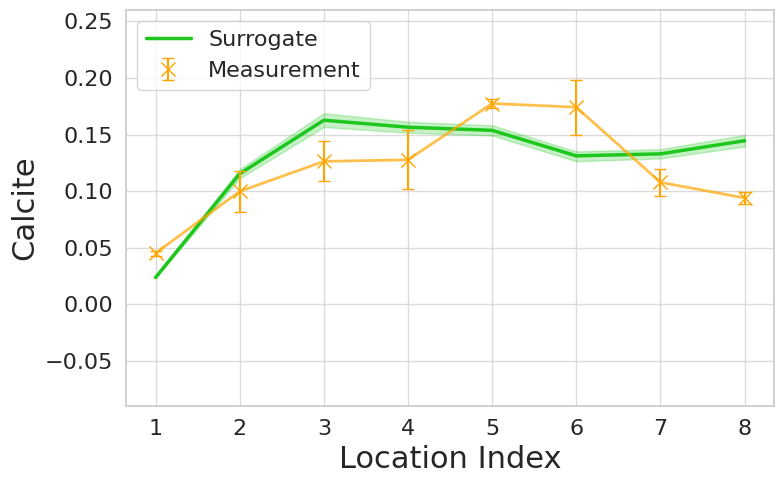

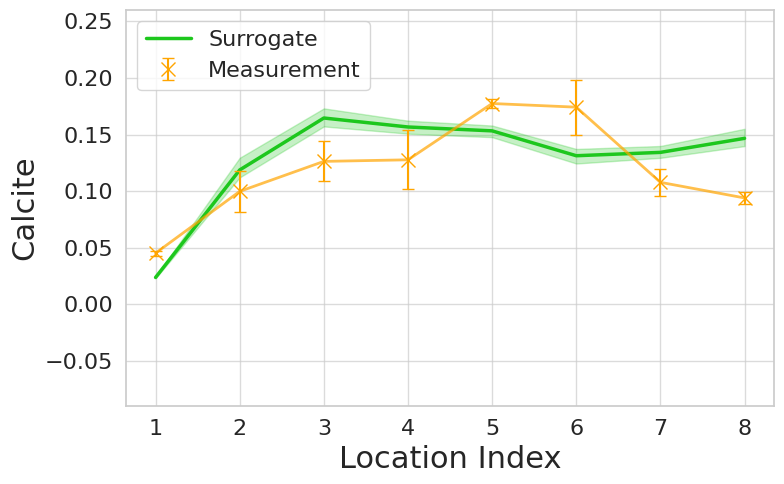

In [98]:
sigmaI = model.sigmaI_measurements
measurement = model.load_ct_measurements()['observations'].flatten()

ylim = (-0.09, 0.26)
vis.plot_surr_prior_predictive(
    out_observations=get_posterior_predictive("mcmc_e_post"),
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    ylim=ylim,
    save_name="micp_post_predictive_e_post"
)
vis.plot_surr_prior_predictive(
    out_observations=get_posterior_predictive("uasabi"),
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    ylim=ylim,
    save_name="micp_post_predictive_uasabi"
)
vis.plot_surr_prior_predictive(
    out_observations=get_posterior_predictive("mcmc_point"),
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    ylim=ylim,
    save_name="micp_post_predictive_point"
)
vis.plot_surr_prior_predictive(
    out_observations=get_posterior_predictive("sabi"),
    measurement=measurement,
    measurement_sigma=sigmaI,
    ci_level=0.90,
    ylim=ylim,
    save_name="micp_post_predictive_sabi"
)